In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns





In [ ]:
# Load the dataset
data = pd.read_csv('/content/Banking_Fraud_Dataset.csv')

In [ ]:

# Feature Engineering
data['Transaction_Time'] = pd.to_datetime(data['Transaction_Time'])
data['Transaction_Hour'] = data['Transaction_Time'].dt.hour
data['Transaction_Day'] = data['Transaction_Time'].dt.day
data['Day_of_Week'] = data['Transaction_Time'].dt.dayofweek

# Customer-level features
customer_stats = data.groupby('Customer_ID').agg({
    'Transaction_ID': 'count',
    'Transaction_Amount': 'mean'
}).rename(columns={'Transaction_ID': 'Customer_Transaction_Count', 'Transaction_Amount': 'Customer_Avg_Amount'})
data = data.merge(customer_stats, on='Customer_ID', how='left')

In [ ]:

# Encode categorical features
data = pd.get_dummies(data, columns=['Transaction_Type', 'Device_Used'], drop_first=True)

# Features and target
features = ['Credit_Score', 'Transaction_Amount', 'Account_Age', 'Customer_Transaction_Count',
            'Customer_Avg_Amount', 'Transaction_Hour', 'Transaction_Day', 'Day_of_Week',
            'Previous_Fraud'] + [col for col in data.columns if col.startswith('Transaction_Type_') or col.startswith('Device_Used_')]
X = data[features]
y = data['Is_Fraud']

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:


# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
# Scale features (for XGBoost, though not strictly needed for Random Forest)
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

# Random Forest with GridSearchCV
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_grid = GridSearchCV(rf, rf_param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train_res, y_train_res)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [ ]:
# Best Random Forest model
best_rf = rf_grid.best_estimator_
y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"Random Forest ROC-AUC: {auc_rf:.3f}")
print(f"Best Random Forest Parameters: {rf_grid.best_params_}")

# XGBoost with class weighting
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='auc')
xgb.fit(X_train_res, y_train_res)
y_pred_proba_xgb = xgb.predict_proba(X_test)[:, 1]
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"XGBoost ROC-AUC: {auc_xgb:.3f}")


Random Forest ROC-AUC: 0.708
Best Random Forest Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
XGBoost ROC-AUC: 0.674


In [ ]:
# Cross-validation for Random Forest
cv_scores = cross_val_score(best_rf, X, y, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
print(f"Random Forest CV ROC-AUC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Detailed evaluation for Random Forest
y_pred_rf = best_rf.predict(X_test)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("\nRandom Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))



Random Forest CV ROC-AUC: 0.724 ± 0.011

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.80      0.78      1432
           1       0.44      0.40      0.42       568

    accuracy                           0.69      2000
   macro avg       0.61      0.60      0.60      2000
weighted avg       0.68      0.69      0.68      2000


Random Forest Confusion Matrix:
[[1144  288]
 [ 341  227]]


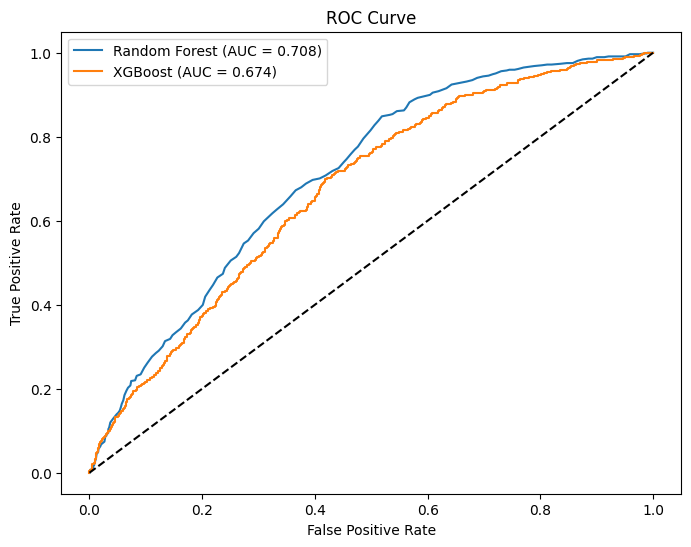

In [ ]:
# Plot ROC curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:


# Feature importance for Random Forest
importances = pd.DataFrame({'Feature': features, 'Importance': best_rf.feature_importances_})
importances = importances.sort_values(by='Importance', ascending=False)
print("\nRandom Forest Feature Importance:")
print(importances)

# Check for overfitting (train vs test AUC)
y_train_pred_proba_rf = best_rf.predict_proba(X_train)[:, 1]
train_auc_rf = roc_auc_score(y_train, y_train_pred_proba_rf)
print(f"\nRandom Forest Training ROC-AUC: {train_auc_rf:.3f}")
print(f"Random Forest Test ROC-AUC: {auc_rf:.3f}")


Random Forest Feature Importance:
                            Feature  Importance
0                      Credit_Score    0.137161
1                Transaction_Amount    0.128311
4               Customer_Avg_Amount    0.117777
5                  Transaction_Hour    0.086858
6                   Transaction_Day    0.086430
2                       Account_Age    0.083328
8                    Previous_Fraud    0.071451
7                       Day_of_Week    0.060432
3        Customer_Transaction_Count    0.042268
10        Transaction_Type_Transfer    0.033456
9   Transaction_Type_Online Payment    0.031335
14                  Device_Used_Web    0.031269
11      Transaction_Type_Withdrawal    0.031199
13         Device_Used_POS Terminal    0.031172
12               Device_Used_Mobile    0.027554

Random Forest Training ROC-AUC: 0.510
Random Forest Test ROC-AUC: 0.708


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
